<a href="https://colab.research.google.com/github/pouya-haghi/ACiS/blob/main/src/resnet18/FineTune_Resenet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.models as models
import numpy as np
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.2MB/s]


In [ ]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# # Modify the last layer of the model
# num_classes = 10 # replace with the number of classes in your dataset
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


In [ ]:
from PIL import Image
img_cat = Image.open("./mycat2.jpg").convert('RGB')

In [ ]:
from torchvision import transforms
#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
#
# Pass the image for preprocessing and the image preprocessed
#
img_cat_preprocessed = preprocess(img_cat)
#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)

In [ ]:
model.eval()
#
# Get the predictions of image as scores related to how the loaded image
# matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
#
out = model(batch_img_cat_tensor)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## weight distribution

<ipython-input-17-3a71670ecc77>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax2.plot(data, normalized_values, 'r.',color='orange', markersize=2, label='(x - mean) / sigma')


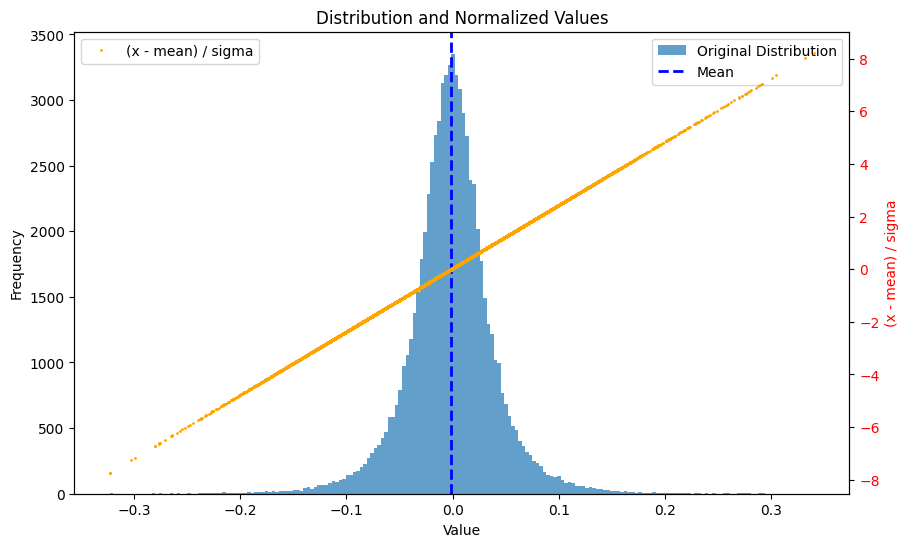

Calculated Mean: -0.00
Calculated Sigma: 0.04


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = list(model.layer2[0].conv1.parameters())[0].detach().numpy().flatten() # At the end, convert to numpy
# Calculate mean and sigma
mean_calculated = np.mean(data)
sigma_calculated = np.std(data)

# Calculate the normalized values
normalized_values = ((data - mean_calculated) / sigma_calculated)

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original distribution
ax1.hist(data, bins=200, alpha=0.7, label='Original Distribution')
ax1.axvline(mean_calculated, color='b', linestyle='dashed', linewidth=2, label='Mean')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Create a secondary y-axis for the normalized values
ax2 = ax1.twinx()
ax2.plot(data, normalized_values, 'r.',color='orange', markersize=2, label='(x - mean) / sigma')
ax2.set_ylabel('(x - mean) / sigma', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend()

# Show the plot
plt.title('Distribution and Normalized Values')
plt.show()

print(f"Calculated Mean: {mean_calculated:.2f}")
print(f"Calculated Sigma: {sigma_calculated:.2f}")

## activation distribution

In [ ]:
import torch

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
# print("device", device)

class ReferenceCounter:
    def __init__(self):
        self.count = 0

    def increase(self):
        self.count += 1

    def get_count(self):
        return self.count

counter = ReferenceCounter()
list_output_activation = {}

def print_activations(module, input, output):
    print(f"Layer: {module.__class__.__name__}")
    # print("Input shape:", input[0].shape)
    ## print("Output shape:", output.shape)
    # print("Output activations:")
    list_output_activation[str(module.__class__.__name__)+str("_")+str(counter.get_count())] = output
    # print(output)
    print("="*50)
    # idx += 1
    counter.increase()

# for name, layer in model.named_children():
#     layer.register_forward_hook(print_activations)

# IN THIS LLM CASE, WE CANT USE model.named_children(): (LIKE MNIST) BECAUSE HERE WE HAVE SUB-LAYERS; INSTEAD REGISTER HOOK FOR EACH LAYER (SUB-LAYER) MANUALLY
model.conv1.register_forward_hook(print_activations)
model.bn1.register_forward_hook(print_activations)
model.relu.register_forward_hook(print_activations)
model.maxpool.register_forward_hook(print_activations)
model.layer1[0].conv1.register_forward_hook(print_activations)
model.layer1[0].bn1.register_forward_hook(print_activations)
model.layer1[0].relu.register_forward_hook(print_activations)
model.layer1[0].conv2.register_forward_hook(print_activations)
model.layer1[0].bn2.register_forward_hook(print_activations)

model.layer1[1].conv1.register_forward_hook(print_activations)
model.layer1[1].bn1.register_forward_hook(print_activations)
model.layer1[1].relu.register_forward_hook(print_activations)
model.layer1[1].conv2.register_forward_hook(print_activations)
model.layer1[1].bn2.register_forward_hook(print_activations)

model.layer2[0].conv1.register_forward_hook(print_activations)
model.layer2[0].bn1.register_forward_hook(print_activations)
model.layer2[0].relu.register_forward_hook(print_activations)
model.layer2[0].conv2.register_forward_hook(print_activations)
model.layer2[0].bn2.register_forward_hook(print_activations)
model.layer2[0].downsample[0].register_forward_hook(print_activations)
model.layer2[0].downsample[1].register_forward_hook(print_activations)

model.layer2[1].conv1.register_forward_hook(print_activations)
model.layer2[1].bn1.register_forward_hook(print_activations)
model.layer2[1].relu.register_forward_hook(print_activations)
model.layer2[1].conv2.register_forward_hook(print_activations)
model.layer2[1].bn2.register_forward_hook(print_activations)

model.layer3[0].conv1.register_forward_hook(print_activations)
model.layer3[0].bn1.register_forward_hook(print_activations)
model.layer3[0].relu.register_forward_hook(print_activations)
model.layer3[0].conv2.register_forward_hook(print_activations)
model.layer3[0].bn2.register_forward_hook(print_activations)
model.layer3[0].downsample[0].register_forward_hook(print_activations)
model.layer3[0].downsample[1].register_forward_hook(print_activations)

model.layer3[1].conv1.register_forward_hook(print_activations)
model.layer3[1].bn1.register_forward_hook(print_activations)
model.layer3[1].relu.register_forward_hook(print_activations)
model.layer3[1].conv2.register_forward_hook(print_activations)
model.layer3[1].bn2.register_forward_hook(print_activations)

model.layer4[0].conv1.register_forward_hook(print_activations)
model.layer4[0].bn1.register_forward_hook(print_activations)
model.layer4[0].relu.register_forward_hook(print_activations)
model.layer4[0].conv2.register_forward_hook(print_activations)
model.layer4[0].bn2.register_forward_hook(print_activations)
model.layer4[0].downsample[0].register_forward_hook(print_activations)
model.layer4[0].downsample[1].register_forward_hook(print_activations)

model.layer4[1].conv1.register_forward_hook(print_activations)
model.layer4[1].bn1.register_forward_hook(print_activations)
model.layer4[1].relu.register_forward_hook(print_activations)
model.layer4[1].conv2.register_forward_hook(print_activations)
model.layer4[1].bn2.register_forward_hook(print_activations)

model.avgpool.register_forward_hook(print_activations)
model.fc.register_forward_hook(print_activations)

out = model(batch_img_cat_tensor)

Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: MaxPool2d
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: Conv2d
Layer: BatchNorm2d
Layer: ReLU
Layer: AdaptiveAvgPool2d
Layer: Linear


In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_4'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_float32_DNN.npy"
np.save(file_name, my_array)

[-1.074669   -0.8501534  -0.9076254  ... -0.67719954 -0.7868077
 -0.3408384 ]


In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_55'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_float32_DNN.npy"
np.save(file_name, my_array)

[-0.02233647  0.06036714  0.0437648  ... -0.09371457 -0.15169416
 -0.14873345]


In [ ]:
import numpy as np
my_array = out.flatten().detach().numpy()
print(my_array)
file_name = "my_array_float32_DNN.npy"
np.save(file_name, my_array)

[-0.6783039  -0.5281743  -0.5088692  -1.5057633  -0.76045865 -0.09840231
 -0.4313057   0.5595901   0.4515084  -0.713765   -1.0548438  -0.83080995
 -0.4277581  -0.972159   -1.2342267  -0.7677086  -0.8468704  -0.29968715
 -0.6312422  -0.6523702  -1.655504   -0.60585344 -1.450314    0.21196207
 -0.99025804 -1.1606699  -0.7948227  -1.1794839  -0.8339969  -0.3803491
 -0.88489217 -0.780373   -0.45982784 -0.47822392 -0.4193215  -0.41368923
  0.5657238  -0.7052442  -0.3367494  -0.01105684 -0.6825777  -0.9563196
 -1.1496882  -0.37166777 -0.75888324 -0.53818274 -0.72337204 -0.5502118
 -1.3281702  -1.204502   -0.5604979   0.51951176 -0.33670878 -0.66072226
 -0.29552275 -1.2346787  -0.3999     -1.5450366  -0.6463898  -0.55774844
  0.74661785  0.18970768 -0.17750855  0.12299117 -0.7905257  -0.25862285
 -0.31748077 -0.5190739  -0.8319693  -1.0458256  -1.6457841   0.07473464
 -1.4058144  -0.24846037 -1.1517735  -1.2969891   0.11871436 -0.55151314
  0.26423836  0.15854932 -0.82543945 -1.5416116  -0.06

<ipython-input-19-87d0fd89c0b7>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax2.plot(data, normalized_values, 'r.',color='orange', markersize=2, label='(x - mean) / sigma')


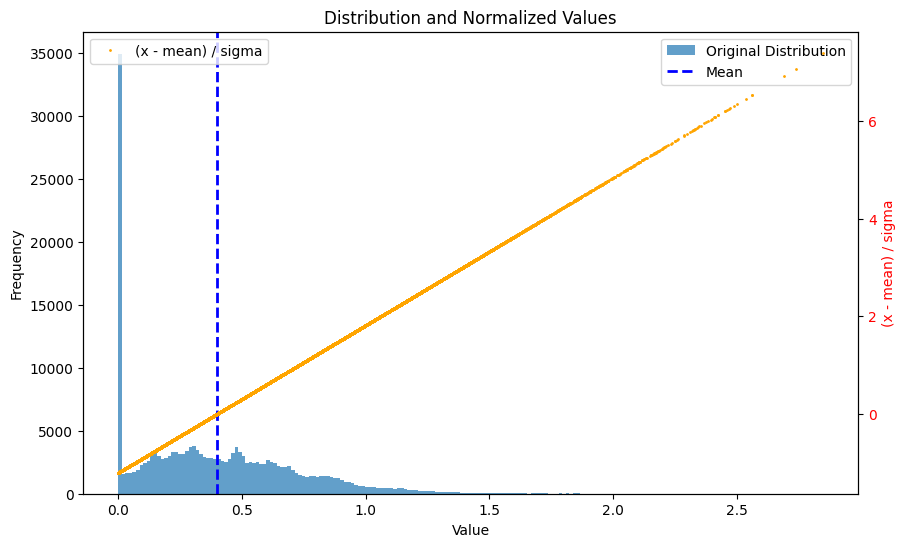

Calculated Mean: 0.40
Calculated Sigma: 0.33


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Linear38 corresponds to the same tensor used for weight distr.
data = list_output_activation['Conv2d_10'][0].flatten().detach().numpy() # At the end, convert to numpy
# Calculate mean and sigma
mean_calculated = np.mean(data)
sigma_calculated = np.std(data)

# Calculate the normalized values
normalized_values = ((data - mean_calculated) / sigma_calculated)

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original distribution
ax1.hist(data, bins=200, alpha=0.7, label='Original Distribution')
ax1.axvline(mean_calculated, color='b', linestyle='dashed', linewidth=2, label='Mean')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Create a secondary y-axis for the normalized values
ax2 = ax1.twinx()
ax2.plot(data, normalized_values, 'r.',color='orange', markersize=2, label='(x - mean) / sigma')
ax2.set_ylabel('(x - mean) / sigma', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend()

# Show the plot
plt.title('Distribution and Normalized Values')
plt.show()

print(f"Calculated Mean: {mean_calculated:.2f}")
print(f"Calculated Sigma: {sigma_calculated:.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rel_error(original_array):
    # Create an array of random float32 values
    # Convert the array to float16
    converted_array = original_array.astype(np.float16)

    # Calculate the relative error
    relative_error = np.abs(original_array - converted_array)
    # print(relative_error[:100])
    # print(original_array[:100])
    # print(converted_array[:100])

    # Create a scatter plot
    plt.scatter(original_array, relative_error, s=5, c='b', alpha=0.5)
    plt.xlabel("Original Values (float32)")
    plt.ylabel("Absolute Error")
    plt.title("Absolute Error when Converting from float32 to float16")
    # plt.xscale("symlog")  # Use symmetrical log scale for better visualization
    plt.yscale("log")
    plt.grid()
    plt.show()


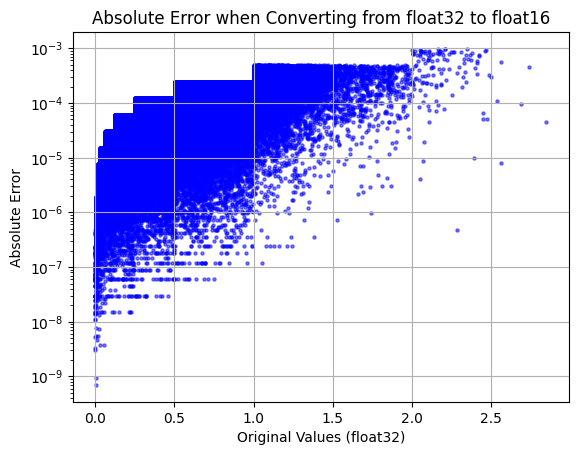

In [ ]:
rel_error(list_output_activation['Conv2d_10'][0].flatten().detach().numpy())

## Modifying weights

In [ ]:
# Quantize weight to float16
# ALTERNATIVELY YOU COULD DO: (model.to(torch.float16)).to(torch.float32) BUT I PREFER THE BELOW METHOD
import torch
for name, param in model.named_parameters():
    param.data = (param.data.to(torch.float16)).to(torch.float32) # convert back to float 32

In [ ]:
# Quantize weight to LNS16
import torch
num_frac = 10
step = 2**(-num_frac)
for name, param in model.named_parameters():
    # print(name)
    original_array = param.data
    if len(original_array.shape) == 1:  # 1D array
        non_zero_indices = original_array.nonzero()
        non_zero_values = original_array[non_zero_indices]
        if len(non_zero_values) > 0:
            log_x = torch.log2(torch.abs(non_zero_values))
            integer_part = log_x.floor()
            frac = torch.abs(log_x - integer_part)
            mul_factor_frac = frac / step
            mul_factor_int = torch.round(mul_factor_frac)
            quant_exponent = integer_part + mul_factor_int * step
            quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
            original_array[non_zero_indices] = quantized_values
    elif len(original_array.shape) == 2:  # 2D array
        non_zero_indices = original_array.nonzero()
        non_zero_values = original_array[non_zero_indices[:, 0], non_zero_indices[:, 1]]
        if len(non_zero_values) > 0:
            log_x = torch.log2(torch.abs(non_zero_values))
            integer_part = log_x.floor()
            frac = torch.abs(log_x - integer_part)
            mul_factor_frac = frac / step
            mul_factor_int = torch.round(mul_factor_frac)
            quant_exponent = integer_part + mul_factor_int * step
            quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
            original_array[non_zero_indices[:, 0], non_zero_indices[:, 1]] = quantized_values
    elif len(original_array.shape) == 3:  # 3D array
        non_zero_indices = original_array.nonzero()
        non_zero_values = original_array[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2]]
        if len(non_zero_values) > 0:
            log_x = torch.log2(torch.abs(non_zero_values))
            integer_part = log_x.floor()
            frac = torch.abs(log_x - integer_part)
            mul_factor_frac = frac / step
            mul_factor_int = torch.round(mul_factor_frac)
            quant_exponent = integer_part + mul_factor_int * step
            quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
            original_array[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2]] = quantized_values
    else:  # 4D array
        non_zero_indices = original_array.nonzero()
        non_zero_values = original_array[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2], non_zero_indices[:, 3]]
        if len(non_zero_values) > 0:
            log_x = torch.log2(torch.abs(non_zero_values))
            integer_part = log_x.floor()
            frac = torch.abs(log_x - integer_part)
            mul_factor_frac = frac / step
            mul_factor_int = torch.round(mul_factor_frac)
            quant_exponent = integer_part + mul_factor_int * step
            quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
            original_array[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2], non_zero_indices[:, 3]] = quantized_values
    param.data = original_array # write back

## modify activation (forward hook)

In [ ]:
# CONVERT TO FLOAT16
# DONT FORGET TO FIRST QUANTIZE WEIGHTS TO FLOAT16
import torch

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
# print("device", device)

class ReferenceCounter:
    def __init__(self):
        self.count = 0

    def increase(self):
        self.count += 1

    def get_count(self):
        return self.count

counter = ReferenceCounter()
list_output_activation = {}

def print_activations(module, input, output):
    # Modify the output tensor
    # if not module.training: # only during eval
    modified_output = (output.to(torch.float16)).to(torch.float32) # convert back to float 32
    list_output_activation[str(module.__class__.__name__)+str("_")+str(counter.get_count())] = modified_output
    counter.increase()
    return modified_output # if you wanna modify the features (the next layer uses the modified values) then you need to "return" it

# for name, layer in model.named_children():
#     layer.register_forward_hook(print_activations)

# IN THIS LLM CASE, WE CANT USE model.named_children(): (LIKE MNIST) BECAUSE HERE WE HAVE SUB-LAYERS; INSTEAD REGISTER HOOK FOR EACH LAYER (SUB-LAYER) MANUALLY
model.conv1.register_forward_hook(print_activations)
model.bn1.register_forward_hook(print_activations)
model.relu.register_forward_hook(print_activations)
model.maxpool.register_forward_hook(print_activations)
model.layer1[0].conv1.register_forward_hook(print_activations)
model.layer1[0].bn1.register_forward_hook(print_activations)
model.layer1[0].relu.register_forward_hook(print_activations)
model.layer1[0].conv2.register_forward_hook(print_activations)
model.layer1[0].bn2.register_forward_hook(print_activations)

model.layer1[1].conv1.register_forward_hook(print_activations)
model.layer1[1].bn1.register_forward_hook(print_activations)
model.layer1[1].relu.register_forward_hook(print_activations)
model.layer1[1].conv2.register_forward_hook(print_activations)
model.layer1[1].bn2.register_forward_hook(print_activations)

model.layer2[0].conv1.register_forward_hook(print_activations)
model.layer2[0].bn1.register_forward_hook(print_activations)
model.layer2[0].relu.register_forward_hook(print_activations)
model.layer2[0].conv2.register_forward_hook(print_activations)
model.layer2[0].bn2.register_forward_hook(print_activations)
model.layer2[0].downsample[0].register_forward_hook(print_activations)
model.layer2[0].downsample[1].register_forward_hook(print_activations)

model.layer2[1].conv1.register_forward_hook(print_activations)
model.layer2[1].bn1.register_forward_hook(print_activations)
model.layer2[1].relu.register_forward_hook(print_activations)
model.layer2[1].conv2.register_forward_hook(print_activations)
model.layer2[1].bn2.register_forward_hook(print_activations)

model.layer3[0].conv1.register_forward_hook(print_activations)
model.layer3[0].bn1.register_forward_hook(print_activations)
model.layer3[0].relu.register_forward_hook(print_activations)
model.layer3[0].conv2.register_forward_hook(print_activations)
model.layer3[0].bn2.register_forward_hook(print_activations)
model.layer3[0].downsample[0].register_forward_hook(print_activations)
model.layer3[0].downsample[1].register_forward_hook(print_activations)

model.layer3[1].conv1.register_forward_hook(print_activations)
model.layer3[1].bn1.register_forward_hook(print_activations)
model.layer3[1].relu.register_forward_hook(print_activations)
model.layer3[1].conv2.register_forward_hook(print_activations)
model.layer3[1].bn2.register_forward_hook(print_activations)

model.layer4[0].conv1.register_forward_hook(print_activations)
model.layer4[0].bn1.register_forward_hook(print_activations)
model.layer4[0].relu.register_forward_hook(print_activations)
model.layer4[0].conv2.register_forward_hook(print_activations)
model.layer4[0].bn2.register_forward_hook(print_activations)
model.layer4[0].downsample[0].register_forward_hook(print_activations)
model.layer4[0].downsample[1].register_forward_hook(print_activations)

model.layer4[1].conv1.register_forward_hook(print_activations)
model.layer4[1].bn1.register_forward_hook(print_activations)
model.layer4[1].relu.register_forward_hook(print_activations)
model.layer4[1].conv2.register_forward_hook(print_activations)
model.layer4[1].bn2.register_forward_hook(print_activations)

model.avgpool.register_forward_hook(print_activations)
model.fc.register_forward_hook(print_activations)

out = model(batch_img_cat_tensor)

In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_4'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_float16_DNN.npy"
np.save(file_name, my_array)

[-1.0742188  -0.85009766 -0.90722656 ... -0.6777344  -0.7871094
 -0.34106445]


In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_55'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_float16_DNN.npy"
np.save(file_name, my_array)

[-0.02233887  0.06048584  0.04367065 ... -0.09350586 -0.15148926
 -0.14868164]


In [ ]:
import numpy as np
my_array = out.flatten().detach().numpy()
print(my_array)
file_name = "my_array_float16_DNN.npy"
np.save(file_name, my_array)

[-0.67822266 -0.52783203 -0.50927734 -1.5058594  -0.76123047 -0.09863281
 -0.4321289   0.56103516  0.45214844 -0.7128906  -1.0546875  -0.8305664
 -0.4272461  -0.97265625 -1.2353516  -0.7680664  -0.84716797 -0.2993164
 -0.63183594 -0.65283203 -1.65625    -0.60546875 -1.4501953   0.21166992
 -0.99072266 -1.1601562  -0.79541016 -1.1796875  -0.8339844  -0.38012695
 -0.88427734 -0.78027344 -0.45947266 -0.47753906 -0.41918945 -0.4128418
  0.56689453 -0.70458984 -0.33691406 -0.01180267 -0.68359375 -0.95703125
 -1.1494141  -0.37060547 -0.75878906 -0.53808594 -0.7236328  -0.55078125
 -1.328125   -1.2041016  -0.5605469   0.5205078  -0.33618164 -0.66064453
 -0.29614258 -1.2353516  -0.40039062 -1.5449219  -0.6455078  -0.55859375
  0.74560547  0.18969727 -0.17785645  0.12219238 -0.7915039  -0.25927734
 -0.31835938 -0.51904297 -0.83251953 -1.0458984  -1.6464844   0.07427979
 -1.40625    -0.24926758 -1.1523438  -1.296875    0.11981201 -0.55126953
  0.2631836   0.15820312 -0.8251953  -1.5419922  -0.06

In [14]:
import numpy as np
loaded_array_32 = np.load("my_array_float32_DNN_last.npy")
print(loaded_array_32)
loaded_array_16 = np.load("my_array_float16_DNN_last.npy")
print(loaded_array_16)

[-0.02233647  0.06036714  0.0437648  ... -0.09371457 -0.15169416
 -0.14873345]
[-0.02233887  0.06048584  0.04367065 ... -0.09350586 -0.15148926
 -0.14868164]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def abs_error(original_array, converted_array):
    abs_error = np.abs(original_array - converted_array)
    plt.scatter(original_array, abs_error, s=5, c='b', alpha=0.5)
    plt.xlabel("Original Values (float32)")
    plt.ylabel("Absolute Error")
    plt.title("Absolute Error when Converting from float32 to float16")
    # plt.xscale("symlog")
    plt.yscale("log")
    plt.grid()
    plt.show()
    print("sum:", sum(abs_error))
    print("max:", max(abs_error))

def rel_error(original_array, converted_array):
    rel_error = np.abs(original_array - converted_array)/np.abs(original_array)
    print("avg relative_error:", sum(rel_error)/len(original_array))

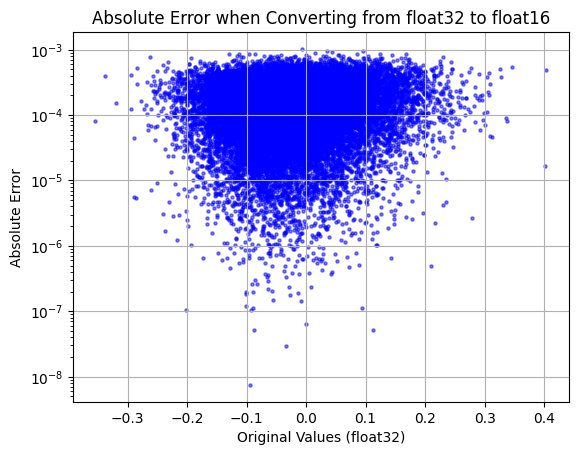

sum: 4.30278449843172
max: 0.0010281913
avg relative_error: 0.017783693354067234


In [16]:
#WITH CONSIDERING ERROR CASCADING FROM PREV LAYERS
abs_error(loaded_array_32, loaded_array_16)
rel_error(loaded_array_32, loaded_array_16)

In [ ]:
# CONVERT TO LNS16
# DONT FORGET TO FIRST QUANTIZE WEIGHTS TO FLOAT16
import torch

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
# print("device", device)

class ReferenceCounter:
    def __init__(self):
        self.count = 0

    def increase(self):
        self.count += 1

    def get_count(self):
        return self.count

counter = ReferenceCounter()
list_output_activation = {}

def print_activations(module, input, output):
    # Modify the output tensor
    # if not module.training: # only during eval
    # print("Name of Layer:", str(module.__class__.__name__))
    # print("shape:", output.shape)
    if len(output.shape) == 4: # 4D
      non_zero_indices = output.nonzero()
      # print("output shape", output.shape)
      # print("non_zero_indices", non_zero_indices.shape)
      non_zero_values = output[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2], non_zero_indices[:, 3]] # 0 because the first dimension is batch, 1 b/c next one is first dimension of feature, 2 b/c it is second dimension of features
      # if activation 2D:  non_zero_indices[:, 0], non_zero_indices[:, 1]
      # if 1D: non_zero_indices
      if len(non_zero_values) > 0:
          log_x = torch.log2(torch.abs(non_zero_values))
          integer_part = log_x.floor()
          frac = torch.abs(log_x - integer_part)
          mul_factor_frac = frac / step
          mul_factor_int = torch.round(mul_factor_frac)
          quant_exponent = integer_part + mul_factor_int * step
          quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
      output[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2], non_zero_indices[:, 3]] = quantized_values
    elif len(output.shape) == 3: # 3D
      non_zero_indices = output.nonzero()
      # print("output shape", output.shape)
      # print("non_zero_indices", non_zero_indices.shape)
      non_zero_values = output[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2]] # 0 because the first dimension is batch, 1 b/c next one is first dimension of feature, 2 b/c it is second dimension of features
      # if activation 2D:  non_zero_indices[:, 0], non_zero_indices[:, 1]
      # if 1D: non_zero_indices
      if len(non_zero_values) > 0:
          log_x = torch.log2(torch.abs(non_zero_values))
          integer_part = log_x.floor()
          frac = torch.abs(log_x - integer_part)
          mul_factor_frac = frac / step
          mul_factor_int = torch.round(mul_factor_frac)
          quant_exponent = integer_part + mul_factor_int * step
          quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
      output[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2]] = quantized_values
    else: # 2D
      non_zero_indices = output.nonzero()
      non_zero_values = output[non_zero_indices[:, 0], non_zero_indices[:, 1]] # 0 because the first dimension is batch, 1 b/c next one is first dimension of feature, 2 b/c it is second dimension of features
      # if activation 2D:  non_zero_indices[:, 0], non_zero_indices[:, 1]
      # if 1D: non_zero_indices
      if len(non_zero_values) > 0:
          log_x = torch.log2(torch.abs(non_zero_values))
          integer_part = log_x.floor()
          frac = torch.abs(log_x - integer_part)
          mul_factor_frac = frac / step
          mul_factor_int = torch.round(mul_factor_frac)
          quant_exponent = integer_part + mul_factor_int * step
          quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
      output[non_zero_indices[:, 0], non_zero_indices[:, 1]] = quantized_values
    # else: #1D
    #   non_zero_indices = output.nonzero()
    #   non_zero_values = output[non_zero_indices] # 0 because the first dimension is batch, 1 b/c next one is first dimension of feature, 2 b/c it is second dimension of features
    #   # if activation 2D:  non_zero_indices[:, 0], non_zero_indices[:, 1]
    #   # if 1D: non_zero_indices
    #   if len(non_zero_values) > 0:
    #       log_x = torch.log2(torch.abs(non_zero_values))
    #       integer_part = log_x.floor()
    #       frac = torch.abs(log_x - integer_part)
    #       mul_factor_frac = frac / step
    #       mul_factor_int = torch.round(mul_factor_frac)
    #       quant_exponent = integer_part + mul_factor_int * step
    #       quantized_values = torch.where(non_zero_values > 0, 2 ** quant_exponent, -2 ** quant_exponent)
    #   output[non_zero_indices] = quantized_values

    list_output_activation[str(module.__class__.__name__)+str("_")+str(counter.get_count())] = output
    counter.increase()
    return output

# for name, layer in model.named_children():
#     layer.register_forward_hook(print_activations)

# IN THIS LLM CASE, WE CANT USE model.named_children(): (LIKE MNIST) BECAUSE HERE WE HAVE SUB-LAYERS; INSTEAD REGISTER HOOK FOR EACH LAYER (SUB-LAYER) MANUALLY
model.conv1.register_forward_hook(print_activations)
model.bn1.register_forward_hook(print_activations)
model.relu.register_forward_hook(print_activations)
model.maxpool.register_forward_hook(print_activations)
model.layer1[0].conv1.register_forward_hook(print_activations)
model.layer1[0].bn1.register_forward_hook(print_activations)
model.layer1[0].relu.register_forward_hook(print_activations)
model.layer1[0].conv2.register_forward_hook(print_activations)
model.layer1[0].bn2.register_forward_hook(print_activations)

model.layer1[1].conv1.register_forward_hook(print_activations)
model.layer1[1].bn1.register_forward_hook(print_activations)
model.layer1[1].relu.register_forward_hook(print_activations)
model.layer1[1].conv2.register_forward_hook(print_activations)
model.layer1[1].bn2.register_forward_hook(print_activations)

model.layer2[0].conv1.register_forward_hook(print_activations)
model.layer2[0].bn1.register_forward_hook(print_activations)
model.layer2[0].relu.register_forward_hook(print_activations)
model.layer2[0].conv2.register_forward_hook(print_activations)
model.layer2[0].bn2.register_forward_hook(print_activations)
model.layer2[0].downsample[0].register_forward_hook(print_activations)
model.layer2[0].downsample[1].register_forward_hook(print_activations)

model.layer2[1].conv1.register_forward_hook(print_activations)
model.layer2[1].bn1.register_forward_hook(print_activations)
model.layer2[1].relu.register_forward_hook(print_activations)
model.layer2[1].conv2.register_forward_hook(print_activations)
model.layer2[1].bn2.register_forward_hook(print_activations)

model.layer3[0].conv1.register_forward_hook(print_activations)
model.layer3[0].bn1.register_forward_hook(print_activations)
model.layer3[0].relu.register_forward_hook(print_activations)
model.layer3[0].conv2.register_forward_hook(print_activations)
model.layer3[0].bn2.register_forward_hook(print_activations)
model.layer3[0].downsample[0].register_forward_hook(print_activations)
model.layer3[0].downsample[1].register_forward_hook(print_activations)

model.layer3[1].conv1.register_forward_hook(print_activations)
model.layer3[1].bn1.register_forward_hook(print_activations)
model.layer3[1].relu.register_forward_hook(print_activations)
model.layer3[1].conv2.register_forward_hook(print_activations)
model.layer3[1].bn2.register_forward_hook(print_activations)

model.layer4[0].conv1.register_forward_hook(print_activations)
model.layer4[0].bn1.register_forward_hook(print_activations)
model.layer4[0].relu.register_forward_hook(print_activations)
model.layer4[0].conv2.register_forward_hook(print_activations)
model.layer4[0].bn2.register_forward_hook(print_activations)
model.layer4[0].downsample[0].register_forward_hook(print_activations)
model.layer4[0].downsample[1].register_forward_hook(print_activations)

model.layer4[1].conv1.register_forward_hook(print_activations)
model.layer4[1].bn1.register_forward_hook(print_activations)
model.layer4[1].relu.register_forward_hook(print_activations)
model.layer4[1].conv2.register_forward_hook(print_activations)
model.layer4[1].bn2.register_forward_hook(print_activations)

model.avgpool.register_forward_hook(print_activations)
model.fc.register_forward_hook(print_activations)

out = model(batch_img_cat_tensor)

In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_4'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_LNS16_DNN.npy"
np.save(file_name, my_array)

[-1.0751159  -0.8500532  -0.90774035 ... -0.6766696  -0.78639185
 -0.34063277]


In [ ]:
import numpy as np
my_array = list_output_activation['Conv2d_55'][0].flatten().detach().numpy()
print(my_array)
file_name = "my_array_LNS16_DNN.npy"
np.save(file_name, my_array)

[-0.02227731  0.06046099  0.04371811 ... -0.09368646 -0.15190592
 -0.14875154]


In [ ]:
import numpy as np
my_array = out.flatten().detach().numpy()
print(my_array)
file_name = "my_array_LNS16_DNN.npy"
np.save(file_name, my_array)

In [17]:
loaded_array_32 = np.load("my_array_float32_DNN_last.npy")
print(loaded_array_32)
loaded_array_16 = np.load("my_array_LNS16_DNN_last.npy")
print(loaded_array_16)

[-0.02233647  0.06036714  0.0437648  ... -0.09371457 -0.15169416
 -0.14873345]
[-0.02227731  0.06046099  0.04371811 ... -0.09368646 -0.15190592
 -0.14875154]


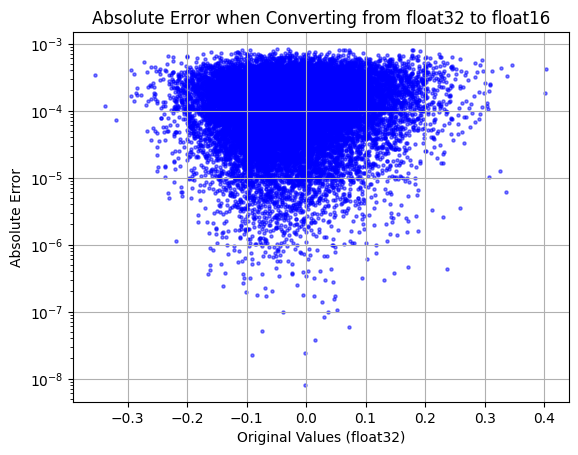

sum: 3.9709248889630544
max: 0.00083369017
avg relative_error: 0.012541079280167525


In [18]:
#WITH CONSIDERING ERROR CASCADING FROM PREV LAYERS
abs_error(loaded_array_32, loaded_array_16)
rel_error(loaded_array_32, loaded_array_16)

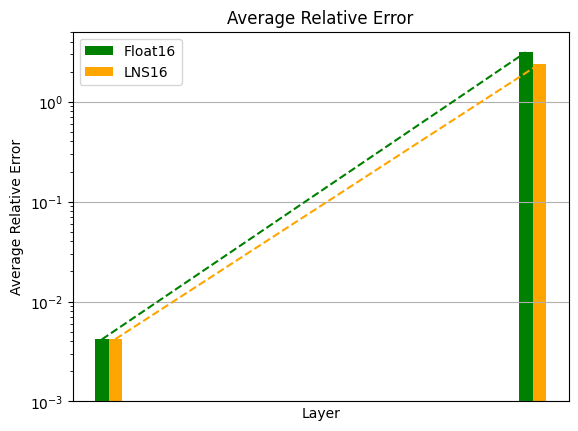

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (y-values)
data1 = np.array([0.004177670452, 3.124890387])  # First line
data2 = np.array([0.004205494635, 2.375399232])    # Second line

# Create an array of x-values (indices)
x_values = np.array([0,11])

# Define the width of the bars (optional)
# Define the width of the bars (optional)
bar_width = 0.35

# Create the bar chart
bar1 = plt.bar(x_values, data1, width=bar_width, label='Float16', color='g', align='center')
bar2 = plt.bar(x_values + bar_width, data2, width=bar_width, label='LNS16', color='orange', align='center')

# Create the line plot on the same plot
plt.plot(x_values, data1, label='Float16', linestyle='--', color='g')
plt.plot(x_values + bar_width, data2, label='LNS16', linestyle='--', color='orange')

# Add labels, title, and legend
plt.xlabel('Layer')
plt.ylabel('Average Relative Error')
plt.title('Average Relative Error')
# plt.xticks(x_values + bar_width / 2, x_values)  # Set x-axis labels based on data indices
plt.xticks([])

plt.yscale('log')  # Set the y-axis scale to logarithmic (optional)
# plt.legend()
plt.ylim(0.001, 5)
plt.legend(handles=[bar1, bar2], labels=['Float16', 'LNS16'])

# Show the plot
plt.grid(axis='y')
plt.show()

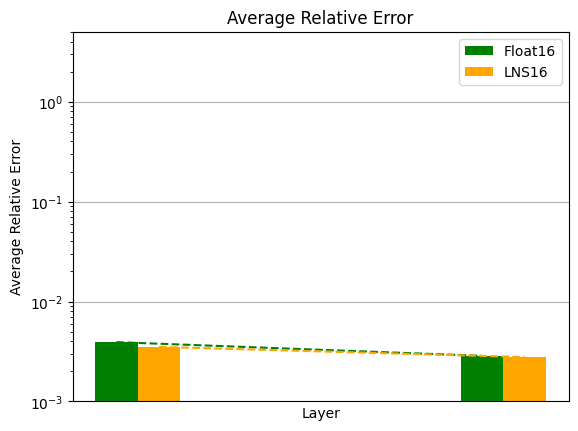

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (y-values)
data1 = np.array([0.003923997003, 0.002858598209])  # First line
data2 = np.array([0.003512810766, 0.002779076377])    # Second line

# Create an array of x-values (indices)
x_values = np.array([1,4])

# Define the width of the bars (optional)
# Define the width of the bars (optional)
bar_width = 0.35

# Create the bar chart
bar1 = plt.bar(x_values, data1, width=bar_width, label='Float16', color='g', align='center')
bar2 = plt.bar(x_values + bar_width, data2, width=bar_width, label='LNS16', color='orange', align='center')

# Create the line plot on the same plot
plt.plot(x_values, data1, label='Float16', linestyle='--', color='g')
plt.plot(x_values + bar_width, data2, label='LNS16', linestyle='--', color='orange')

# Add labels, title, and legend
plt.xlabel('Layer')
plt.ylabel('Average Relative Error')
plt.title('Average Relative Error')
# plt.xticks(x_values + bar_width / 2, x_values)  # Set x-axis labels based on data indices
plt.xticks([])
plt.yscale('log')  # Set the y-axis scale to logarithmic (optional)
plt.ylim(0.001, 5)
# plt.legend()
plt.legend(handles=[bar1, bar2], labels=['Float16', 'LNS16'])

# Show the plot
plt.grid(axis='y')
plt.show()

## classification

In [ ]:
print(out.shape)

torch.Size([1, 1000])


In [ ]:
# if you want the % you can take the softmax:

out = torch.nn.functional.softmax(out, dim=1)[0] * 100

In [ ]:
sorted_indices = np.argsort(out.numpy().flatten())[::-1]

# Get the indices of the top 5 maximum values
print(sorted_indices[:5])

[285 282 281 728 478]


In [ ]:
print(out[sorted_indices[0]]) # print the percentage

tensor(56.2458)


In [ ]:
_, index = torch.max(out, 1)
#
# Find the score in terms of percentage by using torch.nn.functional.softmax function
# which normalizes the output to range [0,1] and multiplying by 100
#
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(percentage[index[0]].item())

20.560869216918945


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
train_dataset = ImageFolder('custom_dataset/train', transform=transform)
val_dataset = ImageFolder('custom_dataset/val', transform=transform)


FileNotFoundError: ignored

In [ ]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [ ]:
from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
